# TP 1 - Partie 1 : Transport Optimal Entropique

## Objectifs

Dans ce notebook, vous allez :
1. Comprendre le lien entre OT entropique et le problème de Schrödinger
2. Implémenter l'algorithme de Sinkhorn avec la bibliothèque POT
3. Visualiser les couplages optimaux entre distributions
4. Explorer l'effet du paramètre de régularisation entropique $\varepsilon$

In [ ]:
%load_ext autoreload
%autoreload 2


import numpy as np
import matplotlib.pyplot as plt
import sys
import ot
sys.path.append('../src')
from simulation import simulate_sde
from functions import compute_ot_coupling, compute_ot_coupling_manual, distribution_distance

# Configuration matplotlib
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Rappels théoriques

### Transport Optimal classique

Étant données deux distributions de probabilité $\mu$ et $\nu$ sur $\mathbb{R}^d$, le problème de transport optimal cherche le couplage $\pi$ qui minimise le coût de transport :

$$
\min_{\pi \in \Pi(\mu, \nu)} \mathbb{E}_{\pi}[c(X, Y)]
$$

où $c(x, y) = |x - y|^2$ est le coût quadratique.

### Transport Optimal Entropique

Pour régulariser le problème et le rendre plus stable numériquement, on ajoute un terme d'entropie :

$$
\gamma^*_{\varepsilon} = \arg\min_{\pi \in \Pi(\mu, \nu)} \left\{ \mathbb{E}_{\pi}[c(X, Y)] + \varepsilon H(\pi) \right\}
$$

où $H(\pi) = -\int \pi(x, y) \log \pi(x, y) dx dy$ est l'entropie de Shannon.

### Lien avec le problème de Schrödinger

Le transport optimal entropique peut s'écrire comme :

$$
\min_{\pi \in \Pi(\mu, \nu)} H\left(\pi \, \Big| \, e^{-\frac{|X-Y|^2}{\varepsilon}}\right)
$$

Cela correspond au problème de Schrödinger : trouver le processus stochastique le plus proche (au sens de l'entropie relative) du mouvement brownien, qui relie $\mu$ à $\nu$.

**Pour l'inférence de trajectoires** : Si $\varepsilon = \sigma \Delta t$ (où $\sigma$ est la diffusion de notre EDS), alors $\gamma^*_{\varepsilon}(x, \cdot)$ correspond au noyau de transition optimal d'une EDS à dérive gradient !

## 2. Chargement des données simulées

On charge les données que vous avez générées dans le notebook `00_introduction`.

In [151]:
# Paramètres de simulation
n_particles = 1000
dim = 2
t0, t1 = 0.0, 1.0
dt = 1e-3
sigma = 3.0
snapshot_times = np.linspace(t0, t1, 6)

# Simulation
snapshots = simulate_sde(
    n_particles=n_particles,
    dim=dim,
    t0=t0,
    t1=t1,
    dt=dt,
    sigma=sigma,
    snapshot_times=snapshot_times,
    seed=42
)

print(f"Nombre de snapshots: {len(snapshots)}")
print(f"Temps des snapshots: {list(snapshots.keys())}")
print(f"Forme de chaque snapshot: {snapshots[t0].shape}")

Nombre de snapshots: 6
Temps des snapshots: [0.0, 0.2, 0.4, 0.6000000000000001, 0.8, 1.0]
Forme de chaque snapshot: (1000, 2)


### Visualisation des distributions temporelles

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


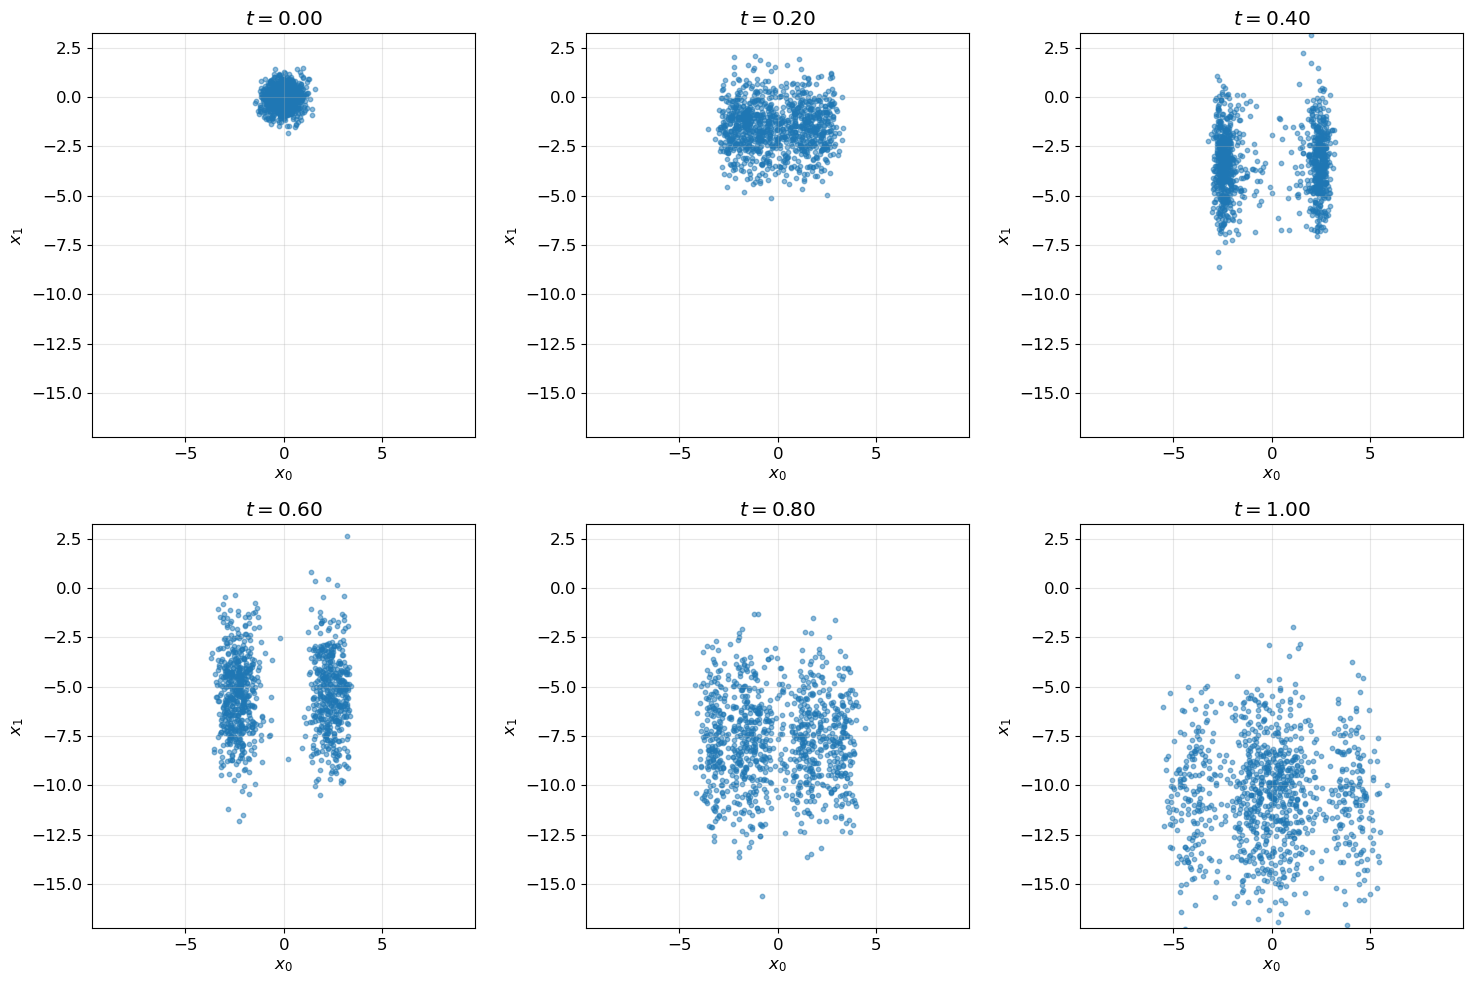

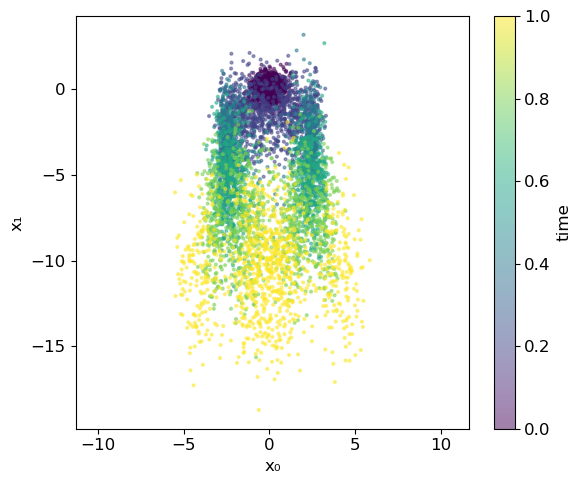

In [152]:
fig, axes = plt.subplots(2, int(len(snapshot_times)/2), figsize=(int(len(snapshot_times)/2)*5, 10))
axes = axes.flatten()

for idx, (t, X) in enumerate(snapshots.items()):
    ax = axes[idx]
    ax.scatter(X[:, 0], X[:, 1], alpha=0.5, s=10)
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.set_title(f'$t = {t:.2f}$')
    ax.axis('equal')
    ax.set_xlim(-10, 10)
    ax.set_ylim(-18, 4)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))

all_X = []
all_t = []

for idx, (t, X) in enumerate(snapshots.items()):
    X = snapshots[t]
    all_X.append(X)
    all_t.append(t * np.ones(len(X)))

all_X = np.vstack(all_X)
all_t = np.concatenate(all_t)

sc = plt.scatter(
    all_X[:, 0],
    all_X[:, 1],
    c=all_t,
    cmap="viridis",
    s=4,
    alpha=0.5,
)

plt.colorbar(sc, label="time")
plt.xlabel("x₀") 
plt.ylabel("x₁") 
plt.axis("equal")
plt.tight_layout()
plt.show()

## 3. Transport Optimal Entropique avec POT

### 3.1 Comprendre l'algorithme de Sinkhorn

L'algorithme de Sinkhorn résout le problème d'OT entropique par une procédure itérative :

$$
\gamma^*_{\varepsilon} = \text{diag}(u) K \text{diag}(v)
$$

où $K_{ij} = e^{-c_{ij}/\varepsilon}$ est le noyau de Gibbs et $(u, v)$ sont les vecteurs de scaling obtenus par itération.

### 3.2 Première application : couplage entre deux snapshots consécutifs

In [153]:
# Prenons deux snapshots consécutifs
times = sorted(snapshots.keys())
t_source = times[2]
t_target = times[3]
delta_t = t_target - t_source

X_source = snapshots[t_source]
X_target = snapshots[t_target]

n_source = len(X_source)
n_target = len(X_target)

print(f"Source: t={t_source:.2f}, {n_source} Cellules")
print(f"Target: t={t_target:.2f}, {n_target} Cellules")
print(f"Δt = {delta_t:.2f}")

Source: t=0.40, 1000 Cellules
Target: t=0.60, 1000 Cellules
Δt = 0.20


### 3.3 Calcul de la matrice de coût

Pour l'OT, on utilise le coût quadratique $c(x, y) = |x - y|^2$.

### 3.4 Calcul du couplage optimal avec Sinkhorn

**Question théorique** : Quel devrait être le bon choix de $\varepsilon$ d'après le cours ?

<details>
<summary>Réponse</summary>
D'après le cours, pour que l'OT entropique corresponde au problème de Schrödinger associé à notre EDS, on doit choisir :
$$\varepsilon = \sigma \Delta t$$
où $\sigma$ est le coefficient de diffusion de notre EDS.
</details>

In [154]:
# Paramètre de régularisation (valeur théorique)
epsilon_theory = sigma * delta_t
print(f"ε théorique = σ × Δt = {sigma} × {delta_t:.2f} = {epsilon_theory:.4f}")

ε théorique = σ × Δt = 3.0 × 0.20 = 0.6000


In [155]:
# Calcul du couplage optimal avec Sinkhorn manuel
gamma_opt_manual = compute_ot_coupling_manual(X_source, X_target, epsilon=epsilon_theory)

print(f"\nForme du couplage optimal: {gamma_opt_manual.shape}")
print(f"Somme du couplage: {gamma_opt_manual.sum():.6f} (devrait être ≈ 1)")


Forme du couplage optimal: (1000, 1000)
Somme du couplage: 1.000000 (devrait être ≈ 1)


In [156]:
# Calcul du couplage optimal avec ot_sinkhorn
gamma_opt = compute_ot_coupling(X_source, X_target, epsilon=epsilon_theory)

print(f"\nForme du couplage optimal: {gamma_opt.shape}")
print(f"Somme du couplage: {gamma_opt.sum():.6f} (devrait être ≈ 1)")


Forme du couplage optimal: (1000, 1000)
Somme du couplage: 1.000000 (devrait être ≈ 1)


/opt/homebrew/Caskroom/miniconda/base/envs/cardamom_light/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:666: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


In [157]:
# Comparaison
diff_gamma = np.linalg.norm(gamma_opt_manual - gamma_opt)

print(f"Somme de la différence des couplages: {diff_gamma.sum():.6f} (devrait être ≈ 0)")

Somme de la différence des couplages: 0.000066 (devrait être ≈ 0)


### 3.5 Visualisation du couplage optimal

On peut visualiser le couplage de plusieurs façons :
1. Matrice de couplage (heatmap)
2. Correspondances entre cellules
3. Transport plan

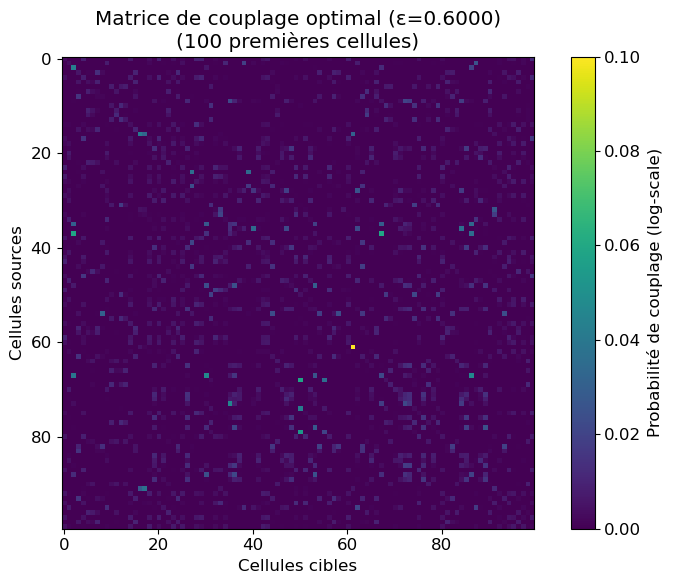

In [158]:
# Visualisation 1 : Matrice de couplage (sous-échantillonnée pour la lisibilité)
n_display = 100
plt.figure(figsize=(8, 6))
plt.imshow(gamma_opt[:n_display, :n_display] * n_source, 
           cmap='viridis', interpolation='nearest', vmin=0, vmax=0.1)
plt.colorbar(label='Probabilité de couplage (log-scale)')
plt.xlabel('Cellules cibles')
plt.ylabel('Cellules sources')
plt.title(f'Matrice de couplage optimal (ε={epsilon_theory:.4f})\n(100 premières cellules)')
plt.tight_layout()
plt.show()

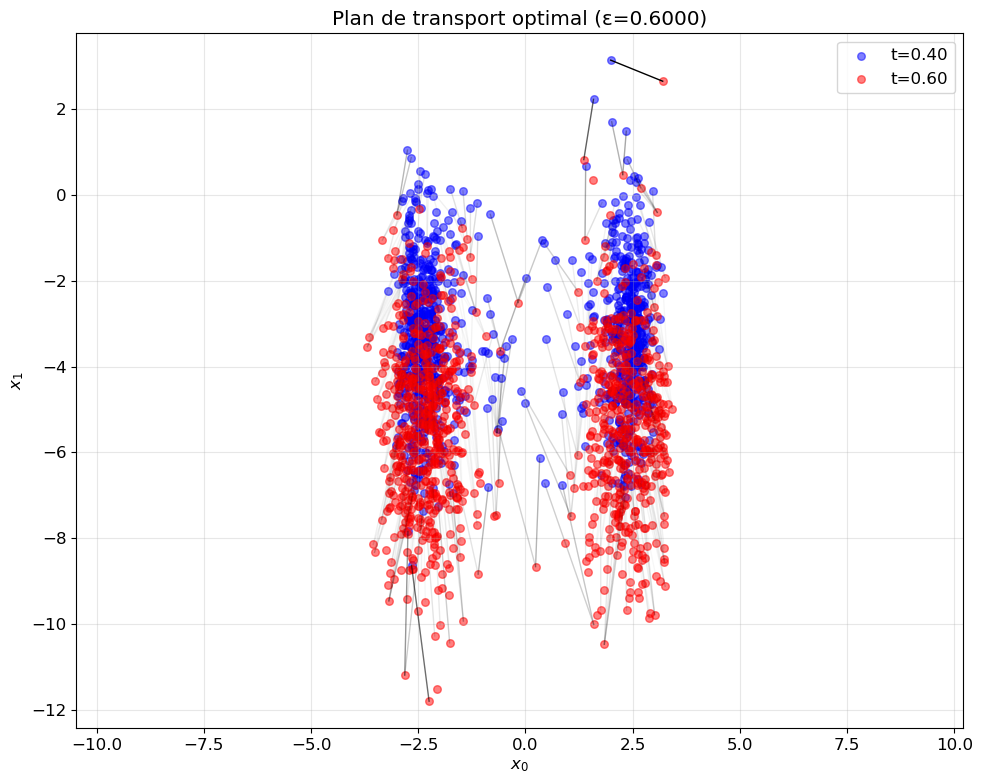

In [159]:
# Visualisation 2 : Plan de transport (on trace quelques connexions)
# Pour chaque particule source, on trouve sa correspondance la plus probable

n_display = 1000  # Nombre de connexions à afficher

fig, ax = plt.subplots(figsize=(10, 8))

# Tracer les distributions
ax.scatter(X_source[:, 0], X_source[:, 1], c='blue', alpha=0.5, s=30, label=f't={t_source:.2f}')
ax.scatter(X_target[:, 0], X_target[:, 1], c='red', alpha=0.5, s=30, label=f't={t_target:.2f}')

# Pour les n_display premières cellule, tracer les connexions principales
weight_max = np.quantile(gamma_opt, q=1) * n_source
for i in range(min(n_display, n_source)):
    # Trouver les k meilleures correspondances
    k = 1
    top_k = np.argsort(gamma_opt[i, :])[-k:]
    
    for j in top_k:
        # Largeur de la ligne proportionnelle à la probabilité de couplage
        weight = gamma_opt[i, j] * n_source
        if weight > .001:  # Seuil pour éviter trop de lignes
            ax.plot([X_source[i, 0], X_target[j, 0]], 
                   [X_source[i, 1], X_target[j, 1]], 
                   'k-', alpha=min(weight/weight_max, 1), linewidth=1)

ax.set_xlabel('$x_0$')
ax.set_ylabel('$x_1$')
ax.set_title(f'Plan de transport optimal (ε={epsilon_theory:.4f})')
ax.legend()
ax.axis('equal')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Exercice : Effet du paramètre de régularisation ε

### Question

Que se passe-t-il quand on fait varier $\varepsilon$ ?
- Quand $\varepsilon \to 0$ : on se rapproche du transport optimal classique (couplage sparse)
- Quand $\varepsilon \to \infty$ : on se rapproche du couplage indépendant $\mu \otimes \nu$ (couplage diffus)

### À faire

Calculez le couplage optimal pour différentes valeurs de $\varepsilon$ et observez :
1. La structure de la matrice de couplage
2. Le coût du transport
3. La "diffusivité" du plan de transport

In [161]:
# Liste de valeurs d'epsilon à tester
epsilons = [
    epsilon_theory / 10,   # Beaucoup moins régularisé
    epsilon_theory / 5,    # Moins régularisé
    epsilon_theory / 2,    # Encore moins régularisé
    epsilon_theory,        # Valeur théorique
    epsilon_theory * 2,    # Plus régularisé
    epsilon_theory * 5,    # Encore Plus régularisé
    epsilon_theory * 10    # Beaucoup plus régularisé
]

# À COMPLÉTER : Calculer les couplages et les coûts pour chaque epsilon
couplings = []
costs = []

for eps in epsilons:
    # Calculer le couplage optimal
    gamma = compute_ot_coupling(X_source, X_target, epsilon=eps)
    
    # Calculer le coût de transport
    cost = np.sum(gamma * ot.dist(X_source, X_target))
    
    couplings.append(gamma)
    costs.append(cost)
    
    print(f"ε = {eps:.6f}, Coût = {cost:.4f}")

/opt/homebrew/Caskroom/miniconda/base/envs/cardamom_light/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:666: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


ε = 0.060000, Coût = 4.4748
ε = 0.120000, Coût = 4.5271
ε = 0.300000, Coût = 4.6733
ε = 0.600000, Coût = 4.8877
ε = 1.200000, Coût = 5.2527
ε = 3.000000, Coût = 6.1661
ε = 6.000000, Coût = 7.7973


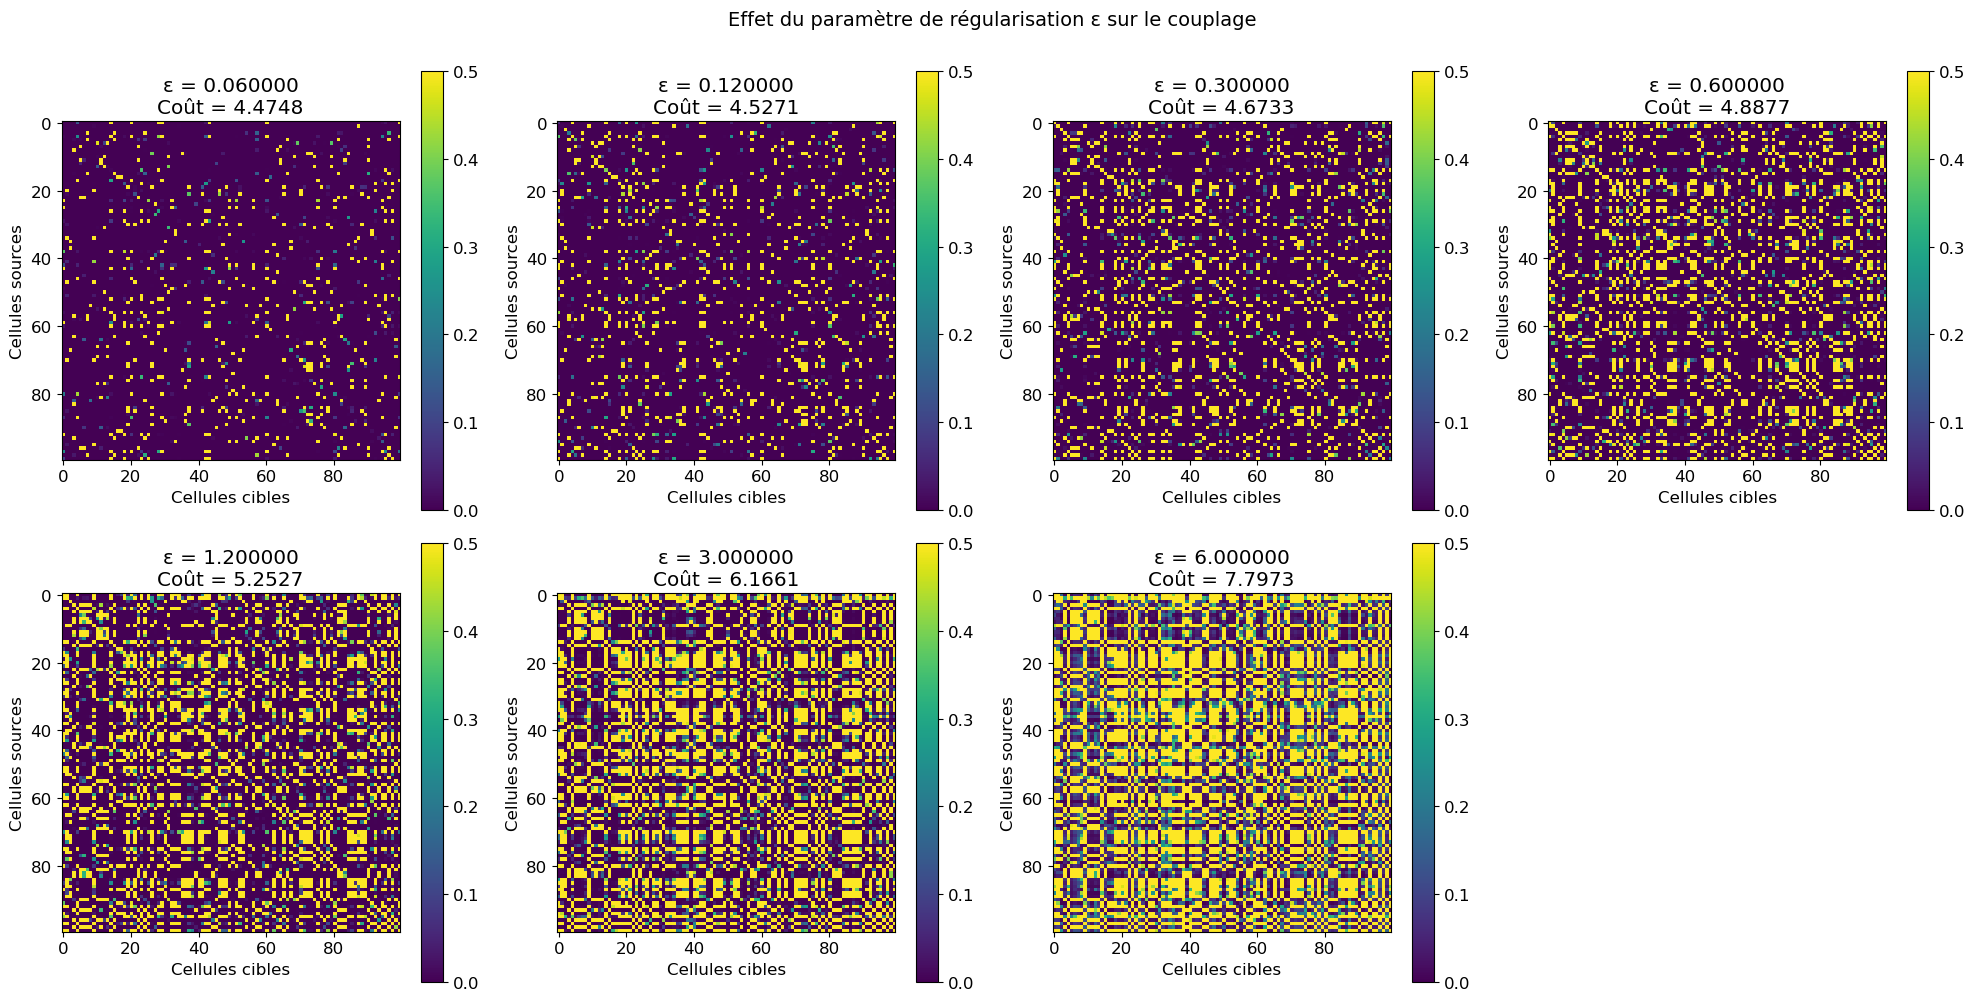

In [162]:
# Visualisation des matrices de couplage pour différents epsilon
fig, axes = plt.subplots(2, int(1+len(epsilons)/2), figsize=(int(1+len(epsilons)/2)*5, 10))
axes = axes.flatten()

n_display = 100

for idx, (eps, gamma) in enumerate(zip(epsilons, couplings)):
    ax = axes[idx]
    im = ax.imshow(gamma[:n_display, :n_display] * n_source * n_target, 
                   cmap='viridis', interpolation='nearest', vmin=0, vmax=.5)
    ax.set_title(f'ε = {eps:.6f}\nCoût = {costs[idx]:.4f}')
    ax.set_xlabel('Cellules cibles')
    ax.set_ylabel('Cellules sources')
    plt.colorbar(im, ax=ax)

axes[-1].axis('off')  # Cacher le dernier subplot vide

plt.suptitle('Effet du paramètre de régularisation ε sur le couplage', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

### Analyse des résultats

**Questions à discuter** :

1. Comment la structure de la matrice de couplage évolue-t-elle avec $\varepsilon$ ?
2. Que se passe-t-il avec le coût de transport quand $\varepsilon$ augmente ?
3. Visuellement, quel $\varepsilon$ semble donner le meilleur compromis ?
4. Pourquoi le choix $\varepsilon = \sigma \Delta t$ a-t-il un sens physique ?

## 5. Mesure de la sparsité du couplage

On peut quantifier la "diffusivité" du couplage en mesurant son entropie :

$$
H(\gamma) = -\sum_{i,j} \gamma_{ij} \log \gamma_{ij}
$$

Plus l'entropie est faible, plus le couplage est concentré (sparse).

<>:16: SyntaxWarning: invalid escape sequence '\e'
<>:24: SyntaxWarning: invalid escape sequence '\e'
<>:16: SyntaxWarning: invalid escape sequence '\e'
<>:24: SyntaxWarning: invalid escape sequence '\e'
/var/folders/lj/409601z9289fp_pv32k6f3frf4h14r/T/ipykernel_46301/2879184371.py:16: SyntaxWarning: invalid escape sequence '\e'
  ax1.set_xlabel('$\epsilon$')
/var/folders/lj/409601z9289fp_pv32k6f3frf4h14r/T/ipykernel_46301/2879184371.py:24: SyntaxWarning: invalid escape sequence '\e'
  ax2.set_xlabel('$\epsilon$')


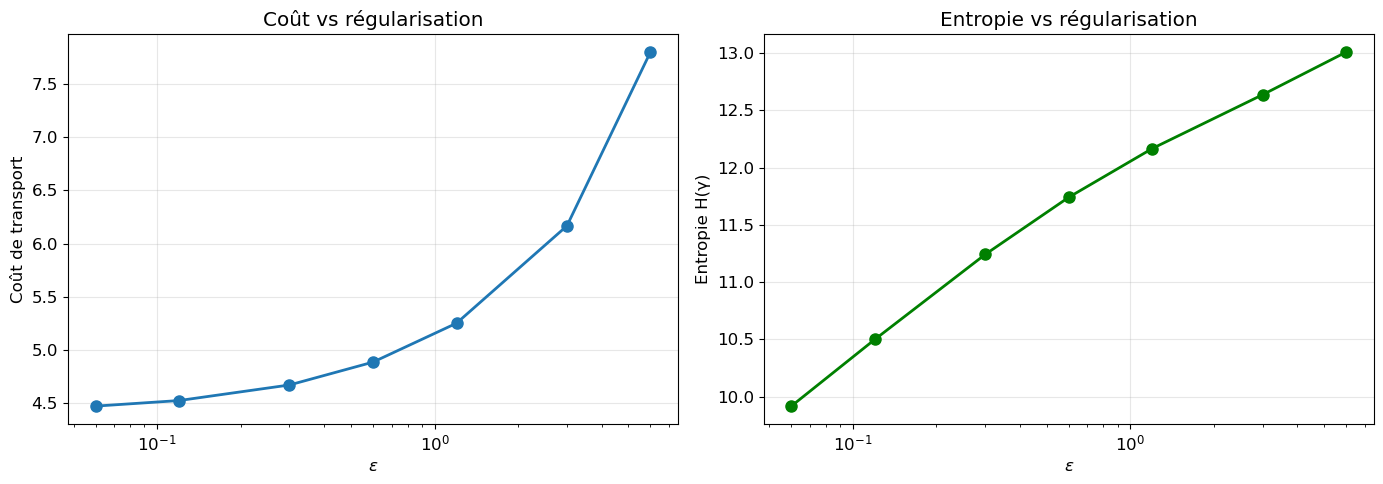


Résumé :
ε = 0.060000 | Coût = 4.4748 | Entropie = 9.92
ε = 0.120000 | Coût = 4.5271 | Entropie = 10.50
ε = 0.300000 | Coût = 4.6733 | Entropie = 11.24
ε = 0.600000 | Coût = 4.8877 | Entropie = 11.74
ε = 1.200000 | Coût = 5.2527 | Entropie = 12.17
ε = 3.000000 | Coût = 6.1661 | Entropie = 12.64
ε = 6.000000 | Coût = 7.7973 | Entropie = 13.01


In [163]:
def compute_entropy(gamma):
    """Calcule l'entropie de Shannon d'un couplage."""
    # Éviter log(0)
    gamma_pos = gamma[gamma > 1e-20]
    return -np.sum(gamma_pos * np.log(gamma_pos))

# Calculer les entropies
entropies = [compute_entropy(gamma) for gamma in couplings]

# Tracer coût vs entropie
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Coût en fonction de epsilon
ax1.plot(epsilons, costs, 'o-', linewidth=2, markersize=8)
ax1.set_xscale('log')
ax1.set_xlabel('$\epsilon$')
ax1.set_ylabel('Coût de transport')
ax1.set_title('Coût vs régularisation')
ax1.grid(True, alpha=0.3)

# Entropie en fonction de epsilon
ax2.plot(epsilons, entropies, 'o-', linewidth=2, markersize=8, color='green')
ax2.set_xscale('log')
ax2.set_xlabel('$\epsilon$')
ax2.set_ylabel('Entropie H(γ)')
ax2.set_title('Entropie vs régularisation')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nRésumé :")
print("="*50)
for eps, cost, entropy in zip(epsilons, costs, entropies):
    print(f"ε = {eps:.6f} | Coût = {cost:.4f} | Entropie = {entropy:.2f}")

## 6. Conclusion

Dans ce notebook, vous avez :

✅ Compris le lien entre OT entropique et le problème de Schrödinger  
✅ Implémenté l'algorithme de Sinkhorn avec POT  
✅ Visualisé les couplages optimaux  
✅ Exploré l'effet du paramètre de régularisation $\varepsilon$  

**Points clés à retenir** :

1. L'OT entropique régularise le problème classique et le rend plus stable numériquement
2. Le choix $\varepsilon = \sigma \Delta t$ a une justification théorique via le problème de Schrödinger
3. Le paramètre $\varepsilon$ contrôle le compromis entre fidélité aux données (coût faible) et régularité (entropie élevée)

**Prochaine étape** : Dans le notebook suivant (`02_trajectory_inference.ipynb`), nous allons utiliser ces couplages pour reconstruire des trajectoires complètes et calculer l'interpolation de McCann.